# Baseline Regression: Causal Forest DML

This notebook reproduces the baseline causal analysis using **Causal Forest Double Machine Learning (CausalForestDML)**. We estimate the effect of digital literacy on the Kakwani inequality index.

- **Treatment (T1)**: three second-level dimensions — Digital device access, Digital information acquisition, Digital platform usage.
- **Treatment (T2)**: one first-level index — Digital literacy.
- **Outcome (Y)**: `kakwani_new`.
- **Covariates (X)**: control variables including region variable (one-hot encoded).

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
import os

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

OUTPUT_DIR = './results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

/Users/yhuang/anaconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## Load data and define variables

Data are read from `data/data.xlsx`. We define:
- **X**: control variables (including City for one-hot encoding).
- **D**: digital literacy measures (treatment dimensions).
- **Y**: outcome (`kakwani_new`, household total income).
- **M**: mediators (online social network, entrepreneurship).

In [2]:
df = pd.read_excel('data/data.xlsx')

X_cols_name = [
    'Gender', 'Age', 'Health status', 'Education level', 'Growing experience',
    'Marital status', 'Growing area', 'Labourer', 'Production facility', 'Storage facility',
    'Agricultural insurance', 'Loan', 'Social expenditure', 'Clan status', 'Natural disaster',
    'Training', 'Brand label usage', 'Logistics convenience', 'City'
]
D_cols_name = [
    'Digital literacy', 'Digital device access', 'Digital information acquisition', 'Digital platform usage'
]

Y_cols_name = ['kakwani_new', 'Household total income']
M_cols_name = ['Online social network',  'Entrepreneurship']

X_df = df[X_cols_name]
D_df = df[D_cols_name]
Y_df = df[Y_cols_name]
M_df = df[M_cols_name]

---
## Preprocessing: encodings for region variable

- **Controls (X)**: One-hot encode `City` 

In [3]:
X = X_df.copy()
categorical_cols = ['City']
enc = OneHotEncoder(drop='first', sparse_output=False)
encoded_region = enc.fit_transform(X[categorical_cols])
encoded_region_df = pd.DataFrame(encoded_region, columns=enc.get_feature_names_out(categorical_cols))
X = pd.concat([X.drop(columns=categorical_cols).reset_index(drop=True), encoded_region_df], axis=1)

print("Covariate matrix X shape after encoding:", X.shape)

Covariate matrix X shape after encoding: (1382, 23)


---
## Covariate correlation (Pearson)

We compute Pearson correlations among control variables. Lower triangle shows significance stars; upper triangle shows correlation coefficients; diagonal is 1.00.

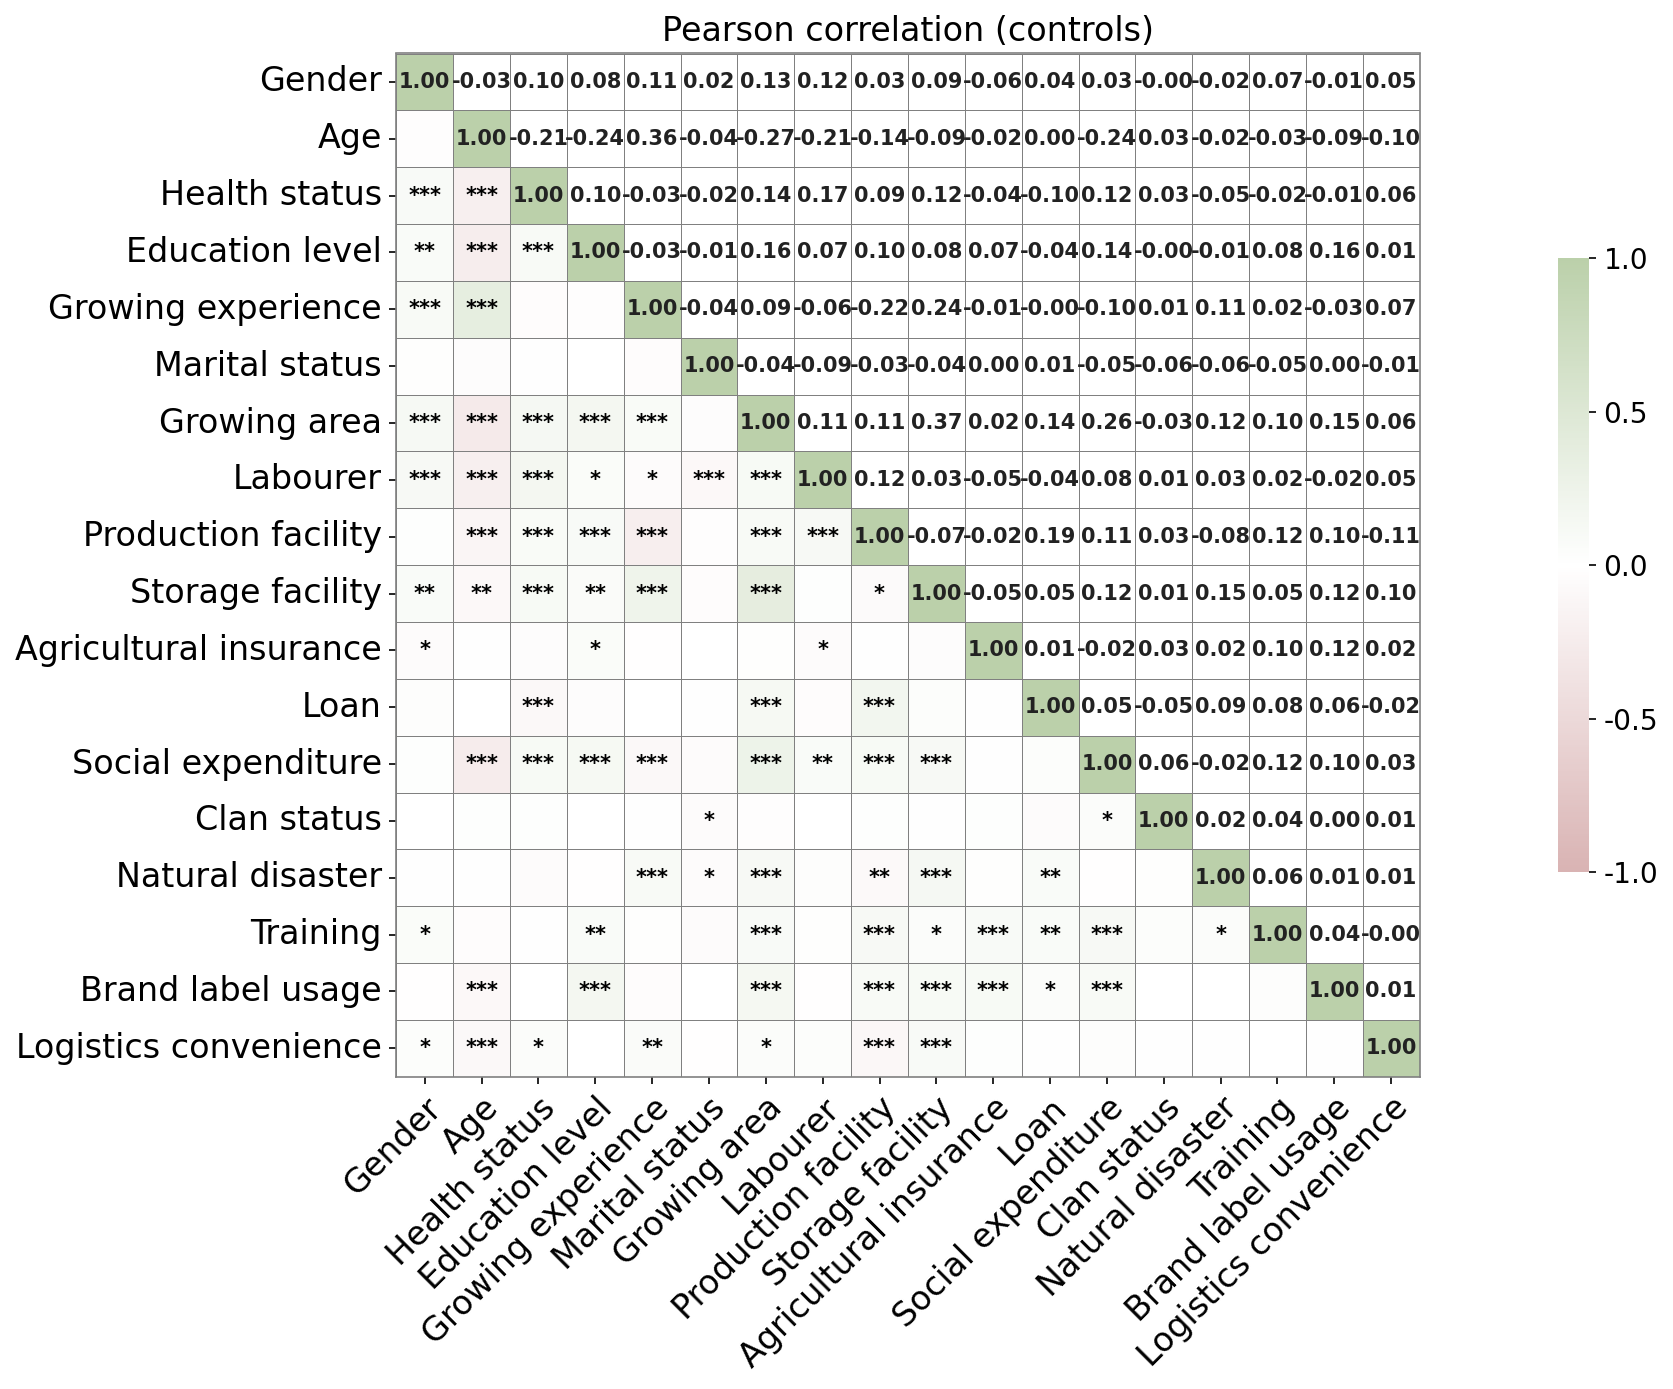

In [4]:
X_corr = X_df.drop(columns=["City"]).apply(pd.to_numeric, errors="coerce")
cols = X_corr.columns.tolist()
n = len(cols)

corr_mat = np.eye(n, dtype=float)
pval_mat = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(i):
        xi, xj = X_corr.iloc[:, i], X_corr.iloc[:, j]
        valid = xi.notna() & xj.notna()
        r, p = pearsonr(xi[valid], xj[valid])
        corr_mat[i, j] = corr_mat[j, i] = r
        pval_mat[i, j] = pval_mat[j, i] = p

corr_df = pd.DataFrame(corr_mat, index=cols, columns=cols)
pval_df = pd.DataFrame(pval_mat, index=cols, columns=cols)

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["#D9B3B3", "#ffffff", "#BBD0AA"], N=256
)
mask_upper = np.triu(np.ones_like(corr_df, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(20, 12), dpi=150)
ax = sns.heatmap(
    corr_df,
    mask=mask_upper,
    cmap=custom_cmap,
    center=0, vmin=-1, vmax=1,
    annot=False,
    square=True,
    linewidths=0.3, linecolor='gray',
    cbar_kws={"shrink": 0.6, "ticks": [-1, -0.5, 0, 0.5, 1]},
    ax=ax
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=13.5)

for i in range(n):
    for j in range(n):
        if i < j:
            ax.text(j + 0.5, i + 0.5, f"{corr_df.iat[i, j]:.2f}",
                    ha='center', va='center', fontsize=10, fontweight='bold', color='#222222')
        elif i > j:
            p = pval_df.iat[i, j]
            stars = '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
            if stars:
                ax.text(j + 0.5, i + 0.5, stars, ha='center', va='center',
                        fontsize=10, color='black', fontweight='bold')
        else:
            ax.text(j + 0.5, i + 0.5, "1.00", ha='center', va='center',
                    fontsize=10, fontweight='bold', color='#222222')

ax.set_xticklabels(cols, fontsize=16)
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_ha('right')
    label.set_rotation_mode('anchor')
ax.set_yticklabels(cols, rotation=0, fontsize=16)
ax.set_title("Pearson correlation (controls)", fontsize=16)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.8)
fig.tight_layout(rect=[0.04, 0.20, 0.98, 0.98])
fig.savefig(f"{OUTPUT_DIR}/corr_heatmap.svg", bbox_inches="tight", pad_inches=0.05)
plt.show()

---
## Model 1: Causal Forest DML — three treatment dimensions (T1)

We use **CausalForestDML** to estimate the effect of the three second-level digital literacy dimensions (Digital device access, Digital information acquisition, Digital platform usage) on `kakwani_new`. 

In [5]:
T1 = D_df[['Digital device access', 'Digital information acquisition', 'Digital platform usage']].values
Y = Y_df['kakwani_new'].values

X_train1, X_test1, T_train1, T_test1, Y_train1, Y_test1 = train_test_split(
    X, T1, Y, test_size=0.3, random_state=42
)

HYPERPARAMS_T1 = {
    "n_estimators": 500,
    "min_samples_split": 50,
    "min_samples_leaf": 18,
    "max_samples": 0.4
}

model_y1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)
model_t1 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)

est1 = CausalForestDML(
    model_y=model_y1,
    model_t=model_t1,
    discrete_treatment=False,
    honest=True,
    inference=True,
    random_state=42,
    **HYPERPARAMS_T1
)
est1.fit(Y_train1, T_train1, X=X_train1)

te_pred = est1.const_marginal_effect(X_test1)
te_lo, te_hi = est1.const_marginal_effect_interval(X_test1, alpha=0.05)

avg_effects = te_pred.mean(axis=0)
avg_ci_lo = te_lo.mean(axis=0)
avg_ci_hi = te_hi.mean(axis=0)

print("Causal Forest DML (T1) fitted. Average effects and 95% CI (test set):")

Causal Forest DML (T1) fitted. Average effects and 95% CI (test set):


**CATE distributions**: histogram for each digital literacy dimension.

Digital device access: ATE = -0.3121, 95% CI = (-0.4860, -0.1383), p ≈ 0.0004


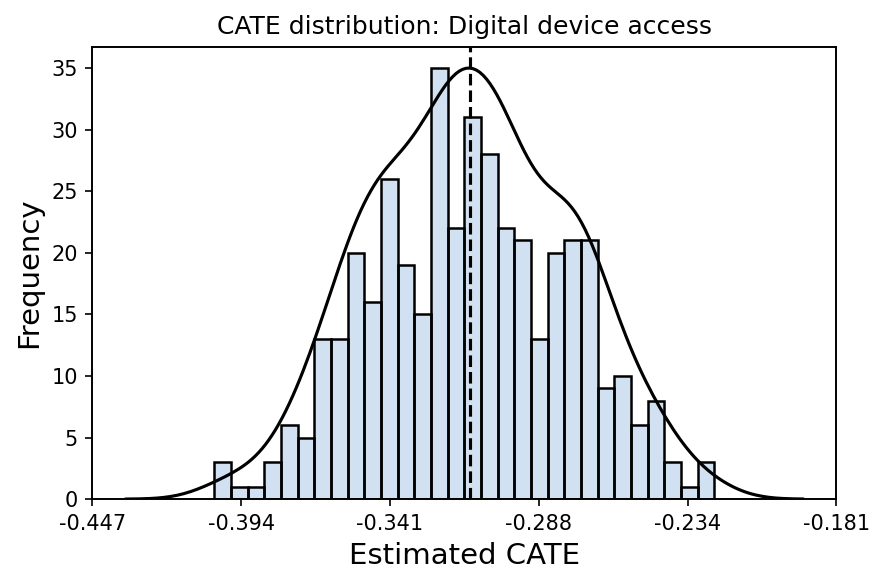

Digital information acquisition: ATE = -0.0608, 95% CI = (-0.1254, 0.0037), p ≈ 0.0645


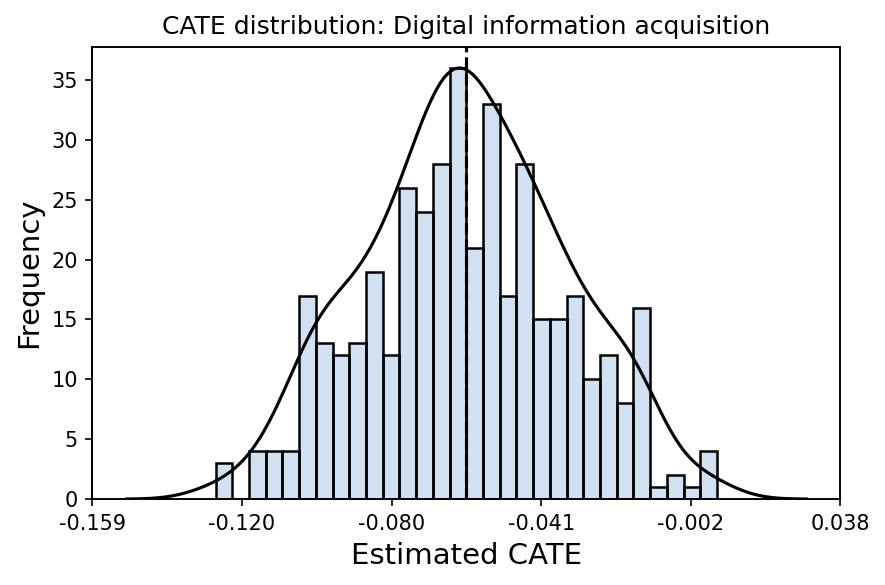

Digital platform usage: ATE = -0.0740, 95% CI = (-0.1307, -0.0173), p ≈ 0.0105


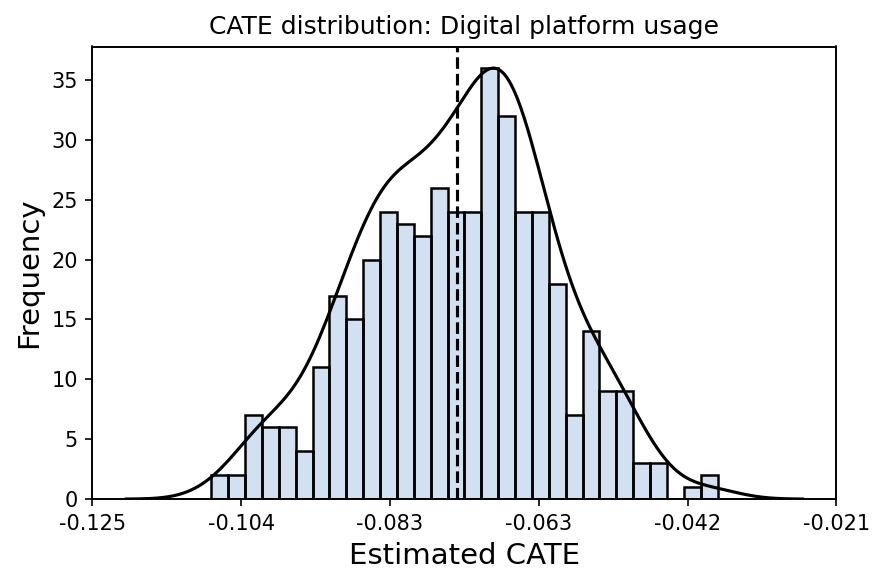

In [6]:
names = ['Digital device access', 'Digital information acquisition', 'Digital platform usage']
results = []

for i, name in enumerate(names):
    vals = te_pred[:, i]
    mean_val = vals.mean()
    stderr = (avg_ci_hi[i] - avg_ci_lo[i]) / (2 * 1.96)
    z_value = avg_effects[i] / stderr if stderr > 0 else np.nan
    p_value = 2 * (1 - norm.cdf(abs(z_value))) if stderr > 0 else np.nan

    print(f"{name}: ATE = {avg_effects[i]:.4f}, 95% CI = ({avg_ci_lo[i]:.4f}, {avg_ci_hi[i]:.4f}), p ≈ {p_value:.4f}")
    results.append({"treatment": name, "ATE": avg_effects[i], "StdErr": stderr, "p_value": p_value})

    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    n, bins, _ = ax.hist(vals, bins=30, color='#8FB4DC', alpha=0.4, edgecolor='none')
    widths = np.diff(bins)
    ax.bar(bins[:-1], n, width=widths, align='edge', facecolor='none', edgecolor='black', linewidth=1.2)
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5)
    ax2 = ax.twinx()
    sns.kdeplot(x=vals, ax=ax2, color='black', linewidth=1.5, bw_adjust=1.0)
    ax2.set_yticks([])
    ax2.set_ylabel("")
    ax.set_xlabel("Estimated CATE", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    x_min, x_max = ax.get_xlim()
    xticks = np.linspace(x_min, x_max, 6)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{t:.3f}" for t in xticks])
    ax.set_title(f"CATE distribution: {name}")
    ax.grid(False)
    fig.tight_layout()
    fig.savefig(f"{OUTPUT_DIR}/CATE_distribution_{i+1}_{name.replace(' ', '_')}.svg", bbox_inches="tight", pad_inches=0.05)
    plt.show()

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(OUTPUT_DIR, "CFDML_direct_results.csv"), index=False, encoding="utf-8-sig")
print("Results saved to CFDML_direct_results.csv")
display(results_df)

Results saved to CFDML_direct_results.csv


,treatment,ATE,StdErr,p_value
0,Digital device access,-0.312147,0.088713,0.000434
1,Digital information acquisition,-0.060849,0.032920,0.064541
2,Digital platform usage,-0.073994,0.028919,0.010507


---
## Model 2: Causal Forest DML — single treatment (Digital literacy, T2)

We estimate the effect of the first-level **Digital literacy** index on `kakwani_new` using the same Causal Forest DML.

In [8]:
T2 = D_df[['Digital literacy']].values
X_train2, X_test2, T_train2, T_test2, Y_train2, Y_test2 = train_test_split(
    X, T2, Y, test_size=0.4, random_state=42
)

HYPERPARAMS_T2 = {
    "discrete_treatment": False,
    "n_estimators": 500,
    "min_samples_split": 50,
    "min_samples_leaf": 18,
    "max_samples": 0.4,
    "min_balancedness_tol": 0.45,
    "honest": True,
    "inference": True,
    "random_state": 42
}

model_y2 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)
model_t2 = RandomForestRegressor(n_estimators=100, min_samples_leaf=10, random_state=42)

est2 = CausalForestDML(
    model_y=model_y2,
    model_t=model_t2,
    **HYPERPARAMS_T2
)
est2.fit(Y_train2, T_train2, X=X_train2)

te_pred2 = est2.const_marginal_effect(X_test2)
te_lo2, te_hi2 = est2.const_marginal_effect_interval(X_test2, alpha=0.05)

avg_effect2 = te_pred2.mean(axis=0)[0]
avg_ci_lo2 = te_lo2.mean(axis=0)[0]
avg_ci_hi2 = te_hi2.mean(axis=0)[0]
stderr2 = (avg_ci_hi2 - avg_ci_lo2) / (2 * 1.96)
z_value2 = avg_effect2 / stderr2
p_value2 = 2 * (1 - norm.cdf(abs(z_value2)))

print("Digital literacy (first-level) on Kakwani index:")
print(f"  ATE ≈ {avg_effect2:.4f}, StdErr ≈ {stderr2:.4f}, p ≈ {p_value2:.4f}")

/Users/yhuang/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/yhuang/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Digital literacy (first-level) on Kakwani index:
  ATE ≈ -0.1448, StdErr ≈ 0.0382, p ≈ 0.0002


**CATE distribution** for Digital literacy.

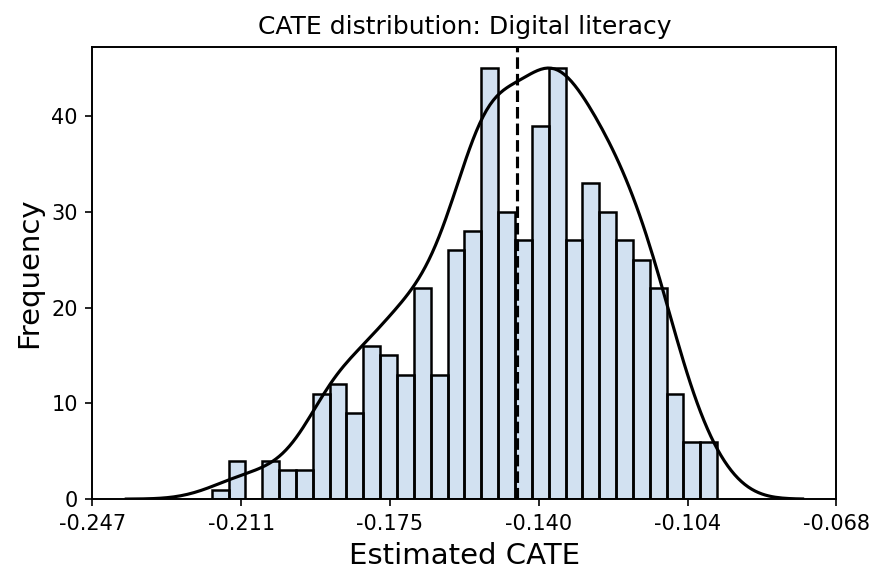

In [9]:
cate_vals = te_pred2.ravel()
mean_val2 = cate_vals.mean()

fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
n, bins, _ = ax.hist(cate_vals, bins=30, color='#8FB4DC', alpha=0.4, edgecolor='none')
widths = np.diff(bins)
ax.bar(bins[:-1], n, width=widths, align='edge', facecolor='none', edgecolor='black', linewidth=1.2)
ax.axvline(mean_val2, color='black', linestyle='--', linewidth=1.5)
ax2 = ax.twinx()
sns.kdeplot(x=cate_vals, ax=ax2, color='black', linewidth=1.5, bw_adjust=1.0)
ax2.set_yticks([])
ax2.set_ylabel("")
ax.set_xlabel("Estimated CATE", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
x_min, x_max = ax.get_xlim()
xticks = np.linspace(x_min, x_max, 6)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t:.3f}" for t in xticks])
ax.set_title("CATE distribution: Digital literacy")
ax.grid(False)
fig.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/CATE_distribution_Digital_literacy.svg", bbox_inches="tight", pad_inches=0.05)
plt.show()